# PGA Tour analysis

This project consist of analysis, clustering and estimating total ranking score of golf players during PGA tournaments in years 2010-2018. Data comes from Kaggle repository https://www.kaggle.com/bradklassen/pga-tour-20102018-data. We use only one of available files. The reason is computational power limitations.

We treat as a data point set of all possible statistics of one player during one season. Thus, we allow one player to be in two different clusters in two different seasons. This assumption seems reasonable, as we can observe changes in styles and performance of sport players over time.

Most commonly used clustering methods are:
* K-Means
* DBSCAN
* Hierarchical clustering (agglomerative and divisive)
* Gaussian mixture model 

We will use K-Means and DBSCAN.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import colors as mcolors
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

Load historic data and see the structure:

In [2]:
df_hist = pd.read_csv('/home/agnieszka/pga-tour-20102018-data/PGA_Data_Historical.csv')
df_hist.head()

,Player Name,Season,Statistic,Variable,Value
0,Robert Garrigus,2010,Driving Distance,Driving Distance - (ROUNDS),71
1,Bubba Watson,2010,Driving Distance,Driving Distance - (ROUNDS),77
2,Dustin Johnson,2010,Driving Distance,Driving Distance - (ROUNDS),83
3,Brett Wetterich,2010,Driving Distance,Driving Distance - (ROUNDS),54
4,J.B. Holmes,2010,Driving Distance,Driving Distance - (ROUNDS),100


## 1. Data preprocessing

Find out whether each variable is associated with only one statistic:

In [3]:
print('Maximal number of unique values in column "Statistic" for one value in column "Variable": {}'\
      .format(df_hist.groupby(by='Variable')['Statistic'].nunique().max()))

Maximal number of unique values in column "Statistic" for one value in column "Variable": 1


Thus, we can drop 'Statistic' column:

In [4]:
df_hist = df_hist.drop('Statistic', axis=1)

We want to change a form of our data to such, that have all variables as columns and each row store all player's results in one season. To do so, let us first check whether there are no duplicates in triples ('Player Name', 'Season', 'Variable'). If there are no duplicates, we set the triple as a new index in data frame.

In [5]:
num_dupl = df_hist.shape[0]-df_hist.drop_duplicates(subset=['Player Name', 'Season', 'Variable']).shape[0]
print('Number of duplicates: {}'.format(num_dupl))

Number of duplicates: 0


Transform the data frame to desired form:

In [6]:
df_hist = df_hist.set_index(['Player Name', 'Variable', 'Season'])['Value'].unstack('Variable').reset_index()
df_hist.head()

Variable,Player Name,Season,% of Potential Pts won - FedExCup Playoffs - (# OF TOP 10'S),% of Potential Pts won - FedExCup Playoffs - (# OF WINS),% of Potential Pts won - FedExCup Playoffs - (%),% of Potential Pts won - FedExCup Playoffs - (EVENTS),% of Potential Pts won - FedExCup Playoffs - (PLAYOFF POINTS WON),% of Potential Pts won - FedExCup Playoffs - (POTENTIAL PTS),% of Potential Pts won - FedExCup Regular Season - (# OF TOP 10'S),% of Potential Pts won - FedExCup Regular Season - (# OF WINS),...,Total Money (Official and Unofficial) - (EVENTS),Total Money (Official and Unofficial) - (MONEY),Total Putting - (EVENTS),Total Putting - (TOTAL),Victory Leaders - (EVENTS),Victory Leaders - (VICTORIES),World Golf Ranking Points - (EVENTS),World Golf Ranking Points - (POINTS),World Money List - (EVENTS),World Money List - (MONEY)
0,A.J. McInerney,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,"$164,923",NaN,NaN,4,NaN,NaN,NaN,NaN,NaN
1,Aaron Baddeley,2010,NaN,NaN,1.55,26,78,"5,000",1,NaN,...,26,"879,317",26,92.4,26,NaN,26,30,27,"879,317"
2,Aaron Baddeley,2011,1,NaN,12.78,22,"1,278","10,000",4,1,...,24,"$3,157,193",22,106.8,22,1,22,155,26,"$3,321,105"
3,Aaron Baddeley,2012,NaN,NaN,2.70,22,135,"5,000",3,NaN,...,22,"$1,215,753",22,116.2,22,NaN,22,66,NaN,NaN
4,Aaron Baddeley,2013,NaN,NaN,5.00,24,125,"2,500",2,NaN,...,24,"$721,024",24,106.1,24,NaN,24,31,NaN,NaN


In [7]:
df_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11223 entries, 0 to 11222
Columns: 2083 entries, Player Name to World Money List - (MONEY)
dtypes: int64(1), object(2082)
memory usage: 178.4+ MB


We can see that almost all columns are of type 'object' (string). We want them to be of numerical type (since clustering methods use distance function). We start with removing or replacing problematic characters

In [8]:
df_hist = df_hist.replace(regex=['\$|,|\+|\s','\-\.','^\.'], value=['','-0.','0.']).replace('E','nan')

Now let us try to convert columns to 'float' type. 

In [9]:
col_fail=[]

for col in df_hist.columns:
    try:
        df_hist[col]=df_hist[col].astype('float')
    except:
        col_fail.append(col)

See where we failed:

In [10]:
df_hist[col_fail].head()

Variable,Player Name,Apex Height - (AVG.),Apex Height - (HIGHEST APEX POINT),Apex Height - (LOWEST APEX POINT),Apex Height - (TOTAL APEX HEIGHT),Approach Putt Performance - (VALUE),Approaches from 100-125 yards (Rgh) - (AVG),Approaches from 100-125 yards - (AVG),Approaches from 125-150 yards (Rgh) - (AVG),Approaches from 125-150 yards - (AVG),...,Proximity to Hole from 30+ yards - (AVG DTP),Proximity to Hole from < 10 yards - (AVG DTP),Proximity to Hole from Fringe - (AVG DTP),Proximity to Hole from Other Locations - (AVG DTP),Proximity to Hole from Rough - (AVG DTP),Proximity to Hole from Sand - (AVG DTP),Putting Average - (GIR RANK),Right Rough Proximity - (AVG),Rough Proximity - (AVG),Scrambling Average Distance to Hole - (AVG DTP)
0,A.J.McInerney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AaronBaddeley,"100'1""","152'0""","64'7""","7703'8""","2'4""","38'8""","20'4""","33'3""","25'5""",...,"10'10""","3'3""","2'7""","6'9""","8'5""","8'0""",164,"46'2""","44'9""","8'7"""
2,AaronBaddeley,"94'1""","144'11""","63'10""","5175'5""","2'3""","24'8""","19'11""","35'11""","21'11""",...,"11'6""","2'11""","2'6""","5'9""","8'1""","8'8""",T97,"42'0""","42'5""","8'6"""
3,AaronBaddeley,"97'2""","126'5""","58'0""","4662'1""","2'4""","36'0""","22'3""","34'6""","25'3""",...,"12'6""","3'4""","3'2""","7'0""","8'2""","7'5""",190,"45'0""","44'7""","8'2"""
4,AaronBaddeley,"92'1""","127'7""","51'3""","4328'5""","2'2""","37'2""","21'1""","35'1""","25'1""",...,"12'9""","3'1""","2'0""","6'1""","7'10""","10'2""",178,"45'0""","45'7""","8'8"""


Convert feet and inches to feets:

In [11]:
def to_feet(s):
    if re.match('\d+\'\d+\"', s):
        return int(re.findall('(\d+)', s)[0])+int(re.findall('(\d+)', s)[1])/12
    elif re.match("\d+\'", s):
        return int(re.findall('(\d+)', s)[0])
    elif re.match('\d+\"', s):
        return int(re.findall('(\d+)', s)[0])/12
    else:
        return s
    
for c in col_fail:
    df_hist[c] = df_hist[c].astype('str').apply(to_feet) 

Again, let us try to convert values to floats and see for which columns we fail: 

In [12]:
col_fail_2=[]

for col in col_fail:
    try:
        df_hist[col]=df_hist[col].astype('float')
    except:
        col_fail_2.append(col)

df_hist[col_fail_2].head()

Variable,Player Name,Going for the Green - Hit Green Pct. - (RTP-NOT GOING FOR THE GRN),Longest Drives - (TOURNAMENT),Longest Hole Outs (in yards) - (TOURNAMENT),Longest Putts - (YEAR/TOURN#),Lowest Round - (TOURN/COURSE),Official World Golf Ranking - (COUNTRY),Putting Average - (GIR RANK)
0,A.J.McInerney,nan,nan,nan,nan,ShrinersHosp/T,nan,nan
1,AaronBaddeley,48Under,nan,WyndhamChampionship,TheGreenbrierClassic,J.Timberlake/T,AUS,164
2,AaronBaddeley,36Under,nan,TOURChampionshipbyCoca-Cola,nan,TOURChamp/East,AUS,T97
3,AaronBaddeley,26Under,HyundaiTournamentofChampions,nan,nan,WGC-Bridgestone,AUS,190
4,AaronBaddeley,24Under,nan,TheBarclays,ShellHoustonOpen,Humana/PGAWest,AUS,178


Above columns are non-numerical, thus we drop them in our analysis (except 'Player Name').

In [13]:
df_hist = df_hist.drop([c for c in col_fail_2 if c!='Player Name'], axis=1)

In [14]:
df_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11223 entries, 0 to 11222
Columns: 2076 entries, Player Name to World Money List - (MONEY)
dtypes: float64(2075), object(1)
memory usage: 177.8+ MB


Now, let us look closer at 'NaN' values in our data frame.

In [15]:
nan_s = df_hist.isna().sum().sum()
nan_p_c = df_hist.isna().mean()
nan_p = nan_p_c.mean()
print("Number of 'NaN' values: {nan_s} \nFraction of 'NaN' values: {nan_p}"\
      .format(nan_s=nan_s, nan_p=round(nan_p, 2)))

Number of 'NaN' values: 20609660 
Fraction of 'NaN' values: 0.88


In [16]:
print("Fraction of 'NaN' values per column:\n\n {}".format(nan_p_c.sort_values()))

Fraction of 'NaN' values per column:

 Variable
Player Name                                                               0.000000
Season                                                                    0.000000
Official World Golf Ranking - (AVG POINTS)                                0.203689
Official World Golf Ranking - (EVENTS)                                    0.203689
Official World Golf Ranking - (TOTAL POINTS)                              0.203689
                                                                            ...   
Distance Analysis 140-150 yards - 5 Iron - (TOTAL ATTEMPTS WITH CLUB)     0.999911
Distance Analysis 210-220 yards - 8 Iron - (ROUNDS)                       0.999911
Distance Analysis 240-260 yards - 8 Iron - (TOTAL ATTEMPTS DIST RANGE)    0.999911
Distance Analysis 120-130 yards - 6 Iron - (TOTAL ATTEMPTS DIST RANGE)    0.999911
FedExCup Season Points - (RESET POINTS)                                   1.000000
Length: 2076, dtype: float64


In [17]:
print('Number of columns with "NaN" fraction below 0.5: {n1} \nNumber of columns with "NaN" fraction below 0.7: {n2}'\
      .format(n1=nan_p_c[nan_p_c<0.5].count(), n2=nan_p_c[nan_p_c<0.7].count()))

Number of columns with "NaN" fraction below 0.5: 8 
Number of columns with "NaN" fraction below 0.7: 50


We can see that we have a big problem with missing values in the data set. One of the solution is to fill 'NaN's with means or medians of columns (I prefer median). In this case it will lead to situation where most of the data are artifitial. We will try this aproach.

Another idea to perform clustering on such data set is to use alternation of K-Means algorithm where distance between two data points is calculated using only common given coordinates.

In [18]:
df = df_hist.fillna(df_hist.median())

/home/agnieszka/daft_env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/agnieszka/daft_env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Check whether there any 'NaN's left:

In [19]:
s = df.isna().sum()
s[s>0]

Variable
FedExCup Season Points - (RESET POINTS)    11223
dtype: int64

In [20]:
df= df.drop('FedExCup Season Points - (RESET POINTS)', axis=1)

Before we can apply clustering algorithm we have to deal with two problematic issues. 
First thing is different scales of variables, which makes them incomparable. Fortunatly, this can be solved by applying one of many scaling methods implemented in scikit-learn module. We choose to use StandardScaler. Second problem is 'Curse of Dimentionality'. We have data points lying in over 2000-dimentional space, this is very inconvenient when performing algorithms based on distance. To deal with that, we apply one of the dimentionality reduction methods. We use Principal Component Analysis (PCA). Another option worth testing is Singular Value Decomposition (SVD).

Data standardizing:

In [21]:
X = np.array(df.iloc[:,2:])
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## 2. Model selection for clustering

Let us use PCA's explained variance ratio to choose range of number of components (n_components) for parameters tuning 

In [22]:
pca = PCA()
pca.fit(X)
print(np.round(pca.explained_variance_ratio_[:30],4))

[0.3436 0.053  0.0499 0.0362 0.0246 0.0209 0.0197 0.0123 0.0108 0.0099
 0.0091 0.008  0.0076 0.0067 0.0063 0.0062 0.006  0.0058 0.0057 0.0055
 0.0055 0.0051 0.0049 0.0046 0.0044 0.0043 0.0041 0.004  0.0039 0.0038]


We are dealing with clustering problem without information about desired grouping of data points, thus we use silhouette score as a measure of performance of our models. For simplicity and due to time constraints we will tune only one parameter (n_components) for PCA transformation and one parameter (n_clusters) for K-Means. We choose model with the highest silhouette score.  

In [23]:
pca_components = np.arange(2,11)
kmeans_clusters = [15, 20, 25]

best_comp=None
best_clus=None
best_score=-2
best_labels = None

for comp, clus in product(pca_components, kmeans_clusters):
    pipe = make_pipeline(PCA(n_components=comp), KMeans(n_clusters=clus, n_init=10))
    y_pipe = pipe.fit_predict(X)
    score = silhouette_score(X,pipe[1].labels_)
    if score> best_score:
        best_score=score
        best_clus=clus
        best_comp=comp
        best_labels = pipe[1].labels_

km_labels= best_labels       
print('Best Silhouette score for k-means: {}'.format(silhouette_score(X,best_labels)))
print('Best n_components: {comp} \nBest n_clusters: {clus}'.format(comp=best_comp, clus=best_clus))

Best Silhouette score for k-means: 0.7304844919736924
Best n_components: 4 
Best n_clusters: 15


Also, we can consider using DBSCAN model instead of K-Means. We tune epsilon and min_samples parameters.

In [24]:
pca_components = np.arange(2,11)
dbscan_eps = [2,3,5]
dbscan_sampl = [2,4,6]

best_comp = None
best_e=None
best_s=None
best_score=-2
best_labels = None

for comp,e,s in product(pca_components, dbscan_eps,dbscan_sampl):
    pipe = make_pipeline(PCA(n_components=comp), DBSCAN(eps=e, min_samples=e, metric='euclidean', n_jobs=-1))
    y_pipe = pipe.fit_predict(X)
    score = silhouette_score(X,pipe[1].labels_)
    if score> best_score:
        best_score=score
        best_comp=comp
        best_e=e
        best_s=s
        best_labels = pipe[1].labels_

db_labels = best_labels
print('Best Silhouette score for DBSCAN: {}'.format(silhouette_score(X,best_labels)))
print('Best n_components: {comp} \nBest epsilon: {e} \nBest min_samples: {s}'\
      .format(comp=best_comp, e=best_e, s=best_s))

Best Silhouette score for DBSCAN: 0.7229516270169167
Best n_components: 5 
Best epsilon: 3 
Best min_samples: 2


Let us now visualize (using t-SNE projection) best clustering found.

In [25]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

In [26]:
colors = ['red', 'blue', 'green', 'black', 'purple', 'yellow', 'brown', 'pink']+list(mcolors.CSS4_COLORS)

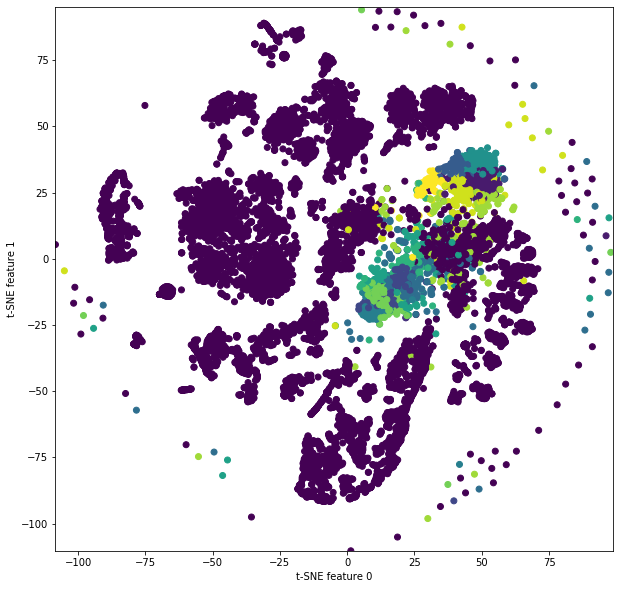

In [27]:
plt.figure(figsize=(10, 10))
plt.xlim(X_tsne[:, 0].min(), X_tsne[:, 0].max() + 1)
plt.ylim(X_tsne[:, 1].min(), X_tsne[:, 1].max() + 1)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=km_labels)
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")
plt.show()

## 3. Predicting total score

We wish to retrieve ranking of players based on other statistics. We choose column 'Official World Golf Ranking - (TOTAL POINTS)' to be our target variable. Thus, we drop all other columns associated with statistic 'Official World Golf Ranking'.

In [28]:
df_temp = pd.read_csv('/home/agnieszka/pga-tour-20102018-data/PGA_Data_Historical.csv')

In [29]:
cols_to_drop = df_temp[(df_temp.Statistic=='Official World Golf Ranking')\
                       &(df_temp.Variable!='Official World Golf Ranking - (TOTAL POINTS)')].Variable.unique()
print(cols_to_drop)

['Official World Golf Ranking - (EVENTS)'
 'Official World Golf Ranking - (AVG POINTS)'
 'Official World Golf Ranking - (POINTS LOST)'
 'Official World Golf Ranking - (POINTS GAINED)'
 'Official World Golf Ranking - (COUNTRY)']


In [30]:
df_2 = df_hist.drop(['Official World Golf Ranking - (EVENTS)', 'Official World Golf Ranking - (AVG POINTS)',\
                        'Official World Golf Ranking - (POINTS LOST)','Official World Golf Ranking - (POINTS GAINED)'],\
                       axis=1)

In [31]:
df_2 = df_2[~df_2['Official World Golf Ranking - (TOTAL POINTS)'].isna()]
df_2 = df_2.fillna(df_2.median())
s = df_2.isna().sum()
s[s>0]

/home/agnieszka/daft_env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/agnieszka/daft_env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Variable
FedExCup Season Points - (RESET POINTS)    8937
dtype: int64

In [32]:
df_2 = df_2.drop('FedExCup Season Points - (RESET POINTS)', axis=1)

Having estimations of total score for each player we can have prediction of ranking. So, we will build and train regression model for estimating total score of players. We choose RandomForestRegressor. First, we split dataset to train and test set.

In [33]:
y = df_2['Official World Golf Ranking - (TOTAL POINTS)']
df_2 = df_2.drop('Official World Golf Ranking - (TOTAL POINTS)', axis=1)

X = np.array(df_2.iloc[:,2:])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
estimators = [10,20,30,40]
depth = [7,9,12,15]
features=[0.5, 0.7, 0.9]

best_score=-10000000
best_e = None
best_d = None
best_f = None

for e,d,f in product(estimators,depth, features):
    forest = RandomForestRegressor(n_estimators=e, max_depth=d, max_features=f)
    forest.fit(X_train, y_train)
    score = forest.score(X_test, y_test)
    if score>best_score:
        best_score = score
        best_e = e
        best_d = d
        best_f = f

print('Best score: {}'.format(best_score))
print('Best n_estimators: {}'.format(best_e))
print('Best max_depth: {}'.format(best_d))
print('Best max_features: {}'.format(best_f))

Best score: 0.8863594546593274
Best n_estimators: 40
Best max_depth: 12
Best max_features: 0.5


We can check which feature was the most important in estimating total score of players.

In [36]:
print('Most important: {}'.format(df_2.columns[forest.feature_importances_.argmax()+2]))
print('Number of splits with that feature: {}'.format(forest.feature_importances_.max()))                            

Most important: Total Money (Official and Unofficial) - (MONEY)
Number of splits with that feature: 0.3910696513606179


## 4. Future work

The biggest weakness of this project is replacing such a huge amount of missing data with median. My next step would be testing clustering with modified K-Means algorithm, where distance from centroids is calculated using only part of coordinates. On the other hand leaving missing data would cause problems with dimentionality reduction.

To find better models one may search bigger parameters grid while tuning.

It would be interesting to see how different clustering models correlate with players performance.

To retrieve ranking of players from other data, one can use regression model and build ranking based on estimated values. Another option is to create a model that given two players' statistics predicts which one is better. 